In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from pymc3.sampling import sample_posterior_predictive
from sklearn.linear_model import LinearRegression
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.validation import _num_samples
import statsmodels.api as sm
import arviz as az
import multiprocessing as mp
import pickle


import utils_reg

In [2]:

waic_section = True
multiplicative = True
charts_section = True
residuals_section = True
coef_inspection = True


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:

with open("model\pymc.pkl", "rb") as input_file:
    pymc = pickle.load(input_file)

In [6]:
trace_points_minute_model = pymc['trace']
points_minute_model = pymc['model']
train = pymc['train']

In [7]:
# WAIC

if waic_section:

    waic = pm.waic(trace_points_minute_model, points_minute_model)

    waic.waic  # waic o elpd_waic
    -2 * waic.waic - waic.p_waic

    pm.summary(trace_points_minute_model).round(2)
    divergent = trace_points_minute_model['diverging']
    print("Number of Divergent %d" % divergent.nonzero()[0].size)

Number of Divergent 0


In [8]:
with points_minute_model:
    post_pred = pm.sample_posterior_predictive(
        trace_points_minute_model, var_names=['pts_minute'])

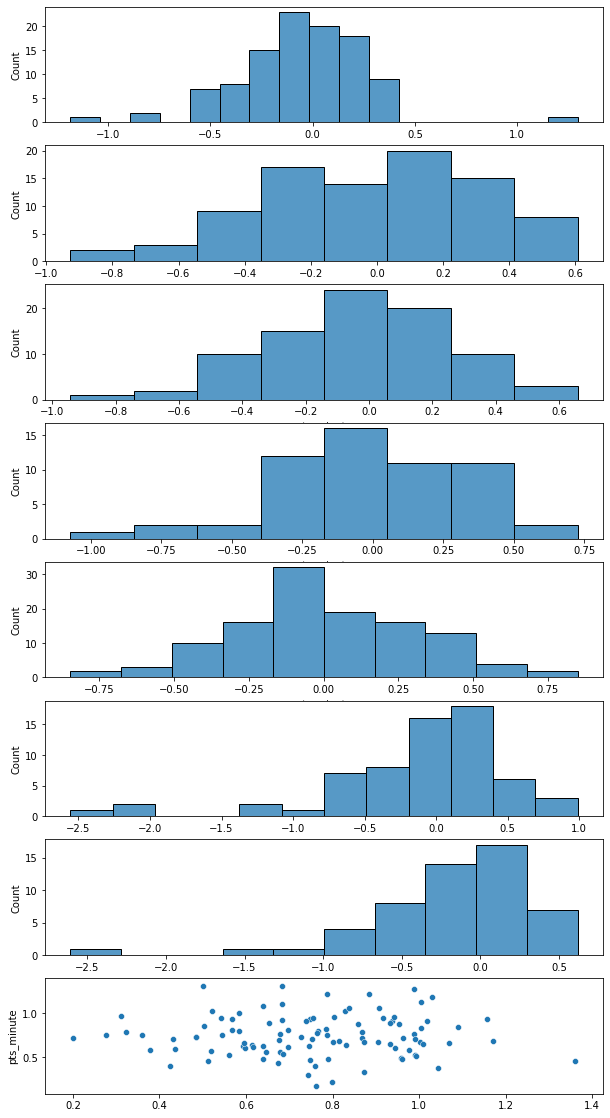

In [9]:
if charts_section:

    charts = 8

    # residuals for particular players

    def res_player(i):
        res = list(post_pred.values())[0][0][train['i'] == i] - \
            train.loc[train['i'] == i, 'pts_minute']
        # sns.scatterplot(x = np.arange(0,len(res)), y = res, ax = axs[i-1])
        # axs[i-1].set(ylabel = "res")
        sns.histplot(x=res, ax=axs[i-1])

    fig, axs = plt.subplots(charts, figsize=(10, 20))
    for i in range(1, charts):
        res_player(i)

    sns.scatterplot(x=list(post_pred.values())[
                    0][0][train['i'] == 8], y=train[train['i'] == 8].pts_minute)


The MSE is training is 0.06953207951981621
The MAPE in training is 0.1836711286741004


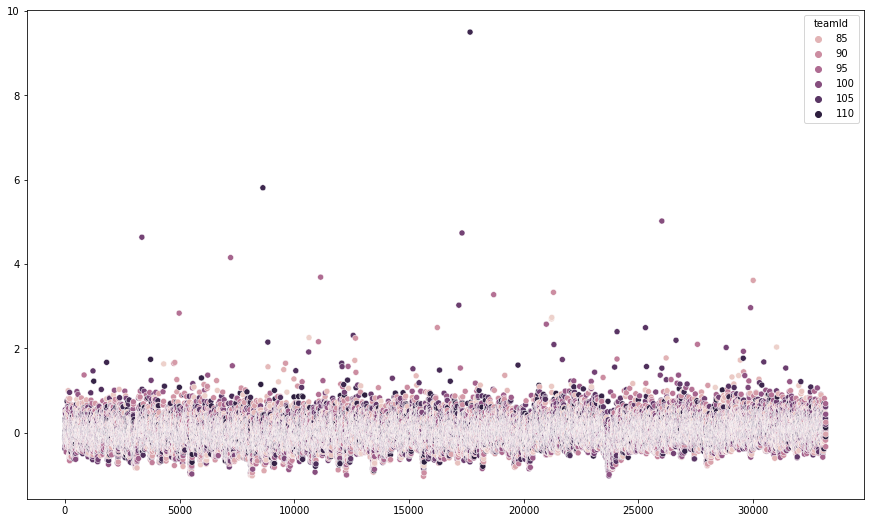

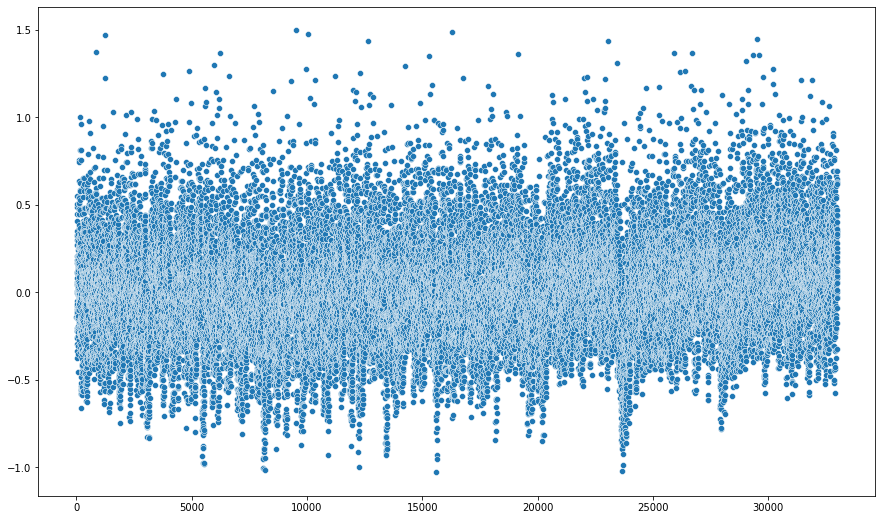

<Figure size 576x4320 with 0 Axes>

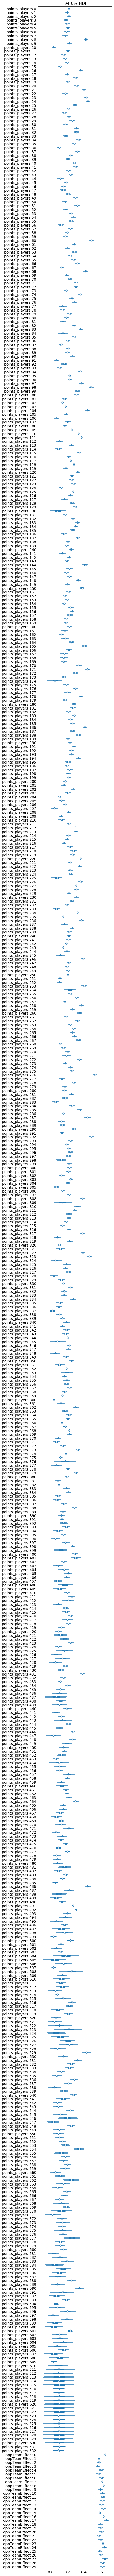

<Figure size 576x4320 with 0 Axes>

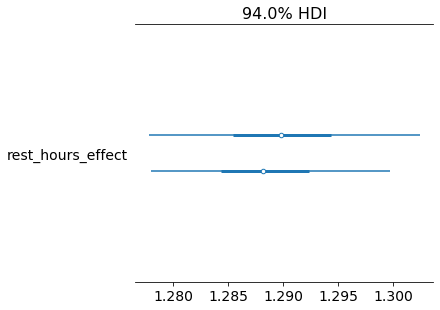

In [11]:

# check residuals
if residuals_section:

    for b in post_pred.values():
        avg_pred = pd.DataFrame(np.transpose(
            b)).add_prefix("sample").mean(axis=1)

    residuals = train.pts_minute - avg_pred

    toplot = residuals[(residuals < 1.5) & (residuals > -1.5)]

    # ALL
    plt.figure(figsize=(15, 9))
    sns.scatterplot(x=np.arange(0, len(residuals)),
                    y=residuals, hue=train.teamId)

    # Without extreme residuals
    plt.figure(figsize=(15, 9))
    sns.scatterplot(x=np.arange(0, len(toplot)),
                    y=toplot)

    plt.figure(figsize=(8, 60))
    pm.forestplot(trace_points_minute_model, var_names=[
                  'points_players', 'oppTeamEffect'])
    plt.figure(figsize=(8, 60))
    pm.forestplot(trace_points_minute_model, var_names=[
                  'rest_hours_effect'])

    # Metrics en training

    def mse(pred, true):
        MSE = ((true - pred)**2).mean()
        # print((true - pred)**2)
        return MSE

    def mape(pred, true):
        MAPE = abs(true-pred).mean()
        return MAPE

    print(f'The MSE is training is {utils_reg.mse(avg_pred, train.pts_minute)}')
   
    print(f'The MAPE in training is {utils_reg.mape(avg_pred, train.pts_minute)}')
    